 149108 average heart rate: 79.51 bpm
 149078 average heart rate: 79.23 bpm


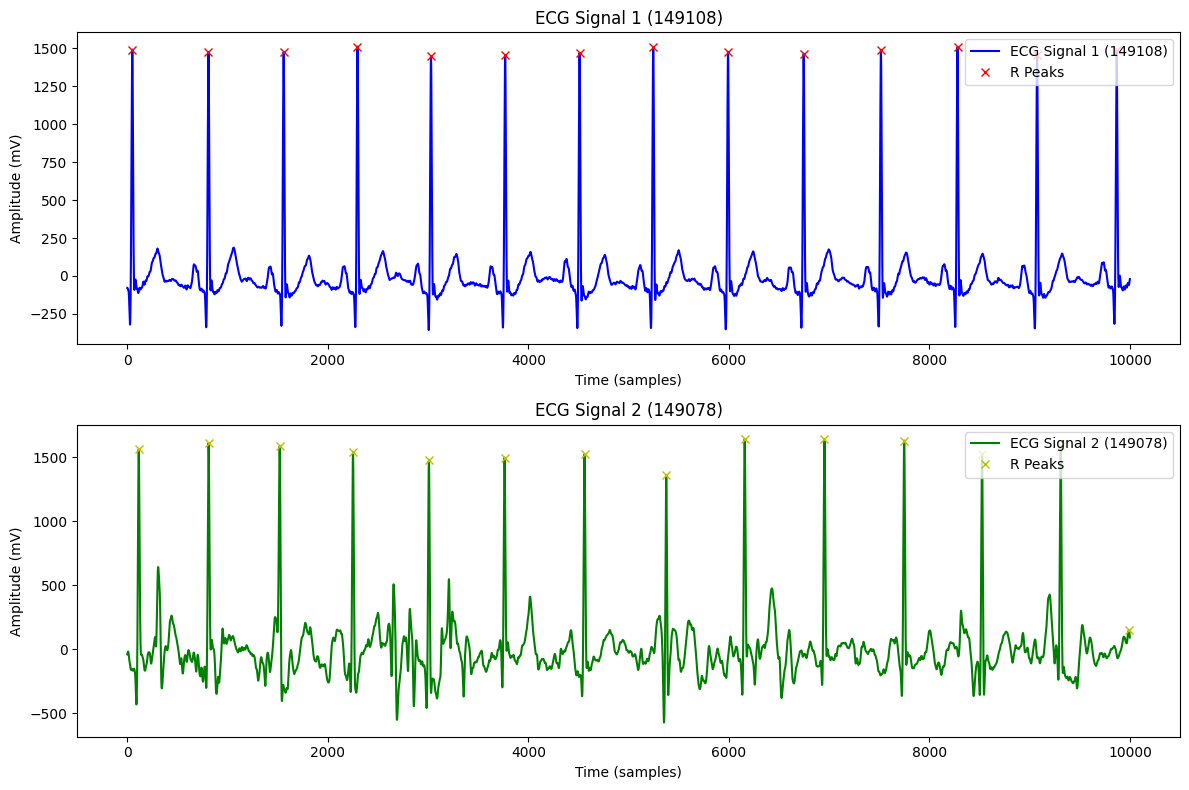

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, iirnotch

def bandpass_filter(signal, fs, lowcut=0.5, highcut=50, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, signal)

def preprocess_ecg(signal, fs):
    signal = bandpass_filter(signal, fs)
    signal = notch_filter(signal, fs)
    return signal

def process_ecg(record_name, color):

    record = wfdb.rdrecord(f'./raw_data/{record_name}/{record_name}_ECG')
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs


    ecg_signal = preprocess_ecg(ecg_signal, fs)

    peaks, _ = find_peaks(ecg_signal, height=0.5, distance=fs * 0.6)


    rr_intervals = np.diff(peaks) / fs * 1000
    heart_rate = 60 / (rr_intervals / 1000)

    avg_hr = np.mean(heart_rate) if len(heart_rate) > 0 else 0
    print(f" {record_name} average heart rate: {avg_hr:.2f} bpm")

    return ecg_signal, peaks, fs, color

file1 = '149108'
file2 = '149078'

signal1, peaks1, fs1, color1 = process_ecg(file1, 'b')
signal2, peaks2, fs2, color2 = process_ecg(file2, 'g')

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(signal1, color=color1, label=f'ECG Signal 1 ({file1})')
axs[0].plot(peaks1, signal1[peaks1], 'rx', label='R Peaks')
axs[0].set_title(f'ECG Signal 1 ({file1})')
axs[0].set_xlabel('Time (samples)')
axs[0].set_ylabel('Amplitude (mV)')
axs[0].legend(loc='upper right')

axs[1].plot(signal2, color=color2, label=f'ECG Signal 2 ({file2})')
axs[1].plot(peaks2, signal2[peaks2], 'yx', label='R Peaks')
axs[1].set_title(f'ECG Signal 2 ({file2})')
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude (mV)')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Average heart rate: 79.51 bpm
Heart rate bonud: 75.57 - 81.86 bpm


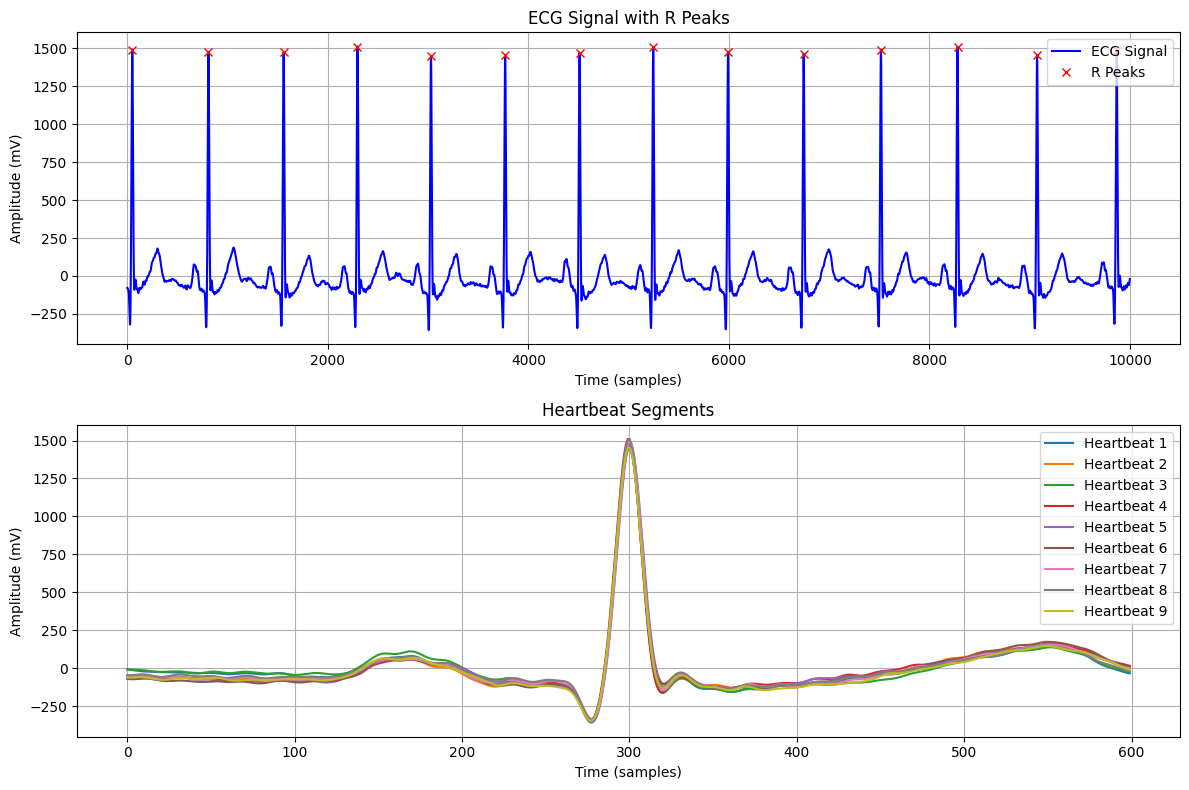

In [4]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, iirnotch

def bandpass_filter(signal, fs, lowcut=0.5, highcut=50, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, signal)

def preprocess_ecg(signal, fs):
    signal = bandpass_filter(signal, fs)
    signal = notch_filter(signal, fs)
    return signal

def analyze_ecg(record_name):
    record = wfdb.rdrecord(f'./raw_data/{record_name}/{record_name}_ECG')
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs


    ecg_signal = preprocess_ecg(ecg_signal, fs)

    peaks, _ = find_peaks(ecg_signal, height=0.5, distance=int(fs * 0.6))

    rr_intervals = np.diff(peaks) / fs * 1000
    heart_rate = 60 / (rr_intervals / 1000)

    heartbeat_segments = []
    buffer_length = int(fs * 0.3)

    for i in range(1, len(peaks) - 1):
        r_peak = peaks[i]
        start = max(0, r_peak - buffer_length)
        end = min(len(ecg_signal), r_peak + buffer_length)
        heartbeat = ecg_signal[start:end]
        heartbeat_segments.append(heartbeat)

    return heartbeat_segments, heart_rate, fs, peaks, ecg_signal

def plot_results(heartbeat_segments, heart_rate, fs, peaks, ecg_signal, num_beats=12):
    print(f"Average heart rate: {np.mean(heart_rate):.2f} bpm")
    print(f"Heart rate bonud: {np.min(heart_rate):.2f} - {np.max(heart_rate):.2f} bpm")

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    axs[0].plot(ecg_signal, 'b', label='ECG Signal')
    axs[0].plot(peaks, ecg_signal[peaks], 'rx', label='R Peaks')
    axs[0].set_title('ECG Signal with R Peaks')
    axs[0].set_xlabel('Time (samples)')
    axs[0].set_ylabel('Amplitude (mV)')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

    for i, heartbeat in enumerate(heartbeat_segments[3:num_beats]):
        axs[1].plot(heartbeat, label=f'Heartbeat {i+1}')
    axs[1].set_title('Heartbeat Segments')
    axs[1].set_xlabel('Time (samples)')
    axs[1].set_ylabel('Amplitude (mV)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    record_name = "149108"
    heartbeat_segments, heart_rate, fs, peaks, ecg_signal = analyze_ecg(record_name)
    plot_results(heartbeat_segments, heart_rate, fs, peaks, ecg_signal)


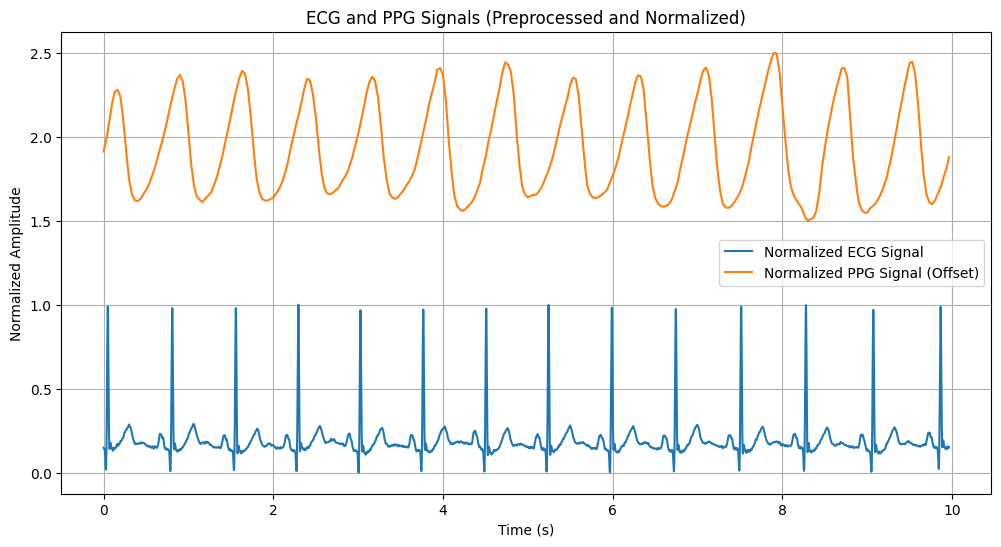

In [6]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, iirnotch
from scipy.interpolate import interp1d

def bandpass_filter(signal, fs, lowcut=0.5, highcut=50, order=2):
    nyquist = 0.5 * fs
    if highcut >= nyquist:
        highcut = nyquist - 0.1
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    if notch >= 1.0:
        return signal
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, signal)

def preprocess_signal(signal, fs):
    signal = bandpass_filter(signal, fs)
    signal = notch_filter(signal, fs)
    return signal

# Read ECG signal
record_name = "149108"

record_ecg = wfdb.rdrecord(f'./raw_data/{record_name}/{record_name}_ECG')
ecg_signal = record_ecg.p_signal[:, 0]
fs_ecg = record_ecg.fs

ecg_signal = preprocess_signal(ecg_signal, fs_ecg)

# Read PPG signal
record_ppg = wfdb.rdrecord(f'./raw_data/{record_name}/{record_name}_PPG')
ppg_signal = record_ppg.p_signal[:, 0]
fs_ppg = record_ppg.fs

ppg_signal = preprocess_signal(ppg_signal, fs_ppg)


if fs_ecg != fs_ppg:
    time_ppg = np.arange(0, len(ppg_signal)) / fs_ppg
    time_ecg = np.arange(0, len(ecg_signal)) / fs_ecg
    max_time = min(time_ppg[-1], time_ecg[-1])
    time_ppg = time_ppg[time_ppg <= max_time]
    time_ecg = time_ecg[time_ecg <= max_time]
    interp_func = interp1d(time_ppg, ppg_signal[:len(time_ppg)], kind='linear', fill_value='extrapolate')
    ppg_signal = interp_func(time_ecg)
    ecg_signal = ecg_signal[:len(ppg_signal)]
    fs = fs_ecg
else:
    fs = fs_ecg

# Normalize signals
def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

normalized_ecg = normalize_signal(ecg_signal)
normalized_ppg = normalize_signal(ppg_signal)

# Offset PPG for separate horizontal display
ppg_offset = 1.5  # Adjust to separate signals
offset_ppg = normalized_ppg + ppg_offset

# Plot signals with same timeline
plt.figure(figsize=(12, 6))
time_axis = np.arange(len(normalized_ecg)) / fs  # Time in seconds

plt.plot(time_axis, normalized_ecg, label='Normalized ECG Signal')
plt.plot(time_axis, offset_ppg, label='Normalized PPG Signal (Offset)')

# Add labels, title, and legend
plt.title('ECG and PPG Signals (Preprocessed and Normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid()
plt.show()


c:\Users\panda\Desktop\COMP_456F_FPY\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33287 (\N{CJK UNIFIED IDEOGRAPH-8207}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\panda\Desktop\COMP_456F_FPY\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35338 (\N{CJK UNIFIED IDEOGRAPH-8A0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\panda\Desktop\COMP_456F_FPY\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34399 (\N{CJK UNIFIED IDEOGRAPH-865F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\panda\Desktop\COMP_456F_FPY\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34701 (\N{CJK UNIFIED IDEOGRAPH-878D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\panda\Desktop\COMP_456F_FPY\venv\lib\site-packages\IPython\core\pylabtools.py:170: User

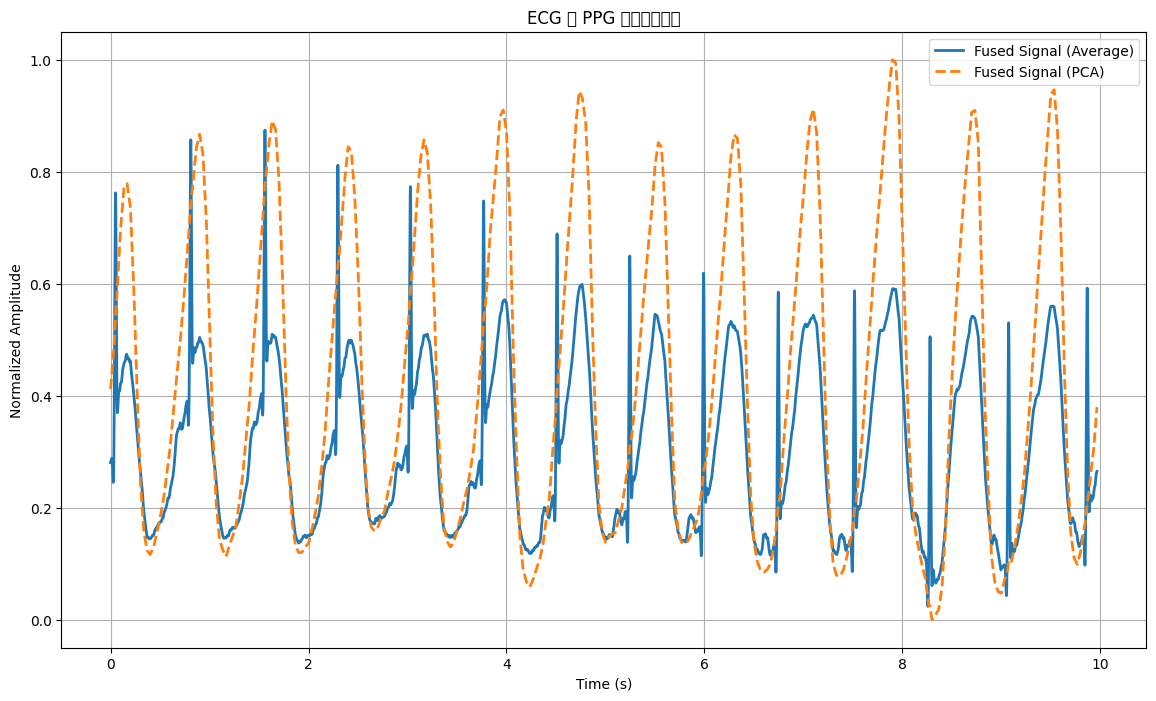

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

def bandpass_filter(signal, fs, lowcut=0.5, highcut=50, order=2):
    nyquist = 0.5 * fs
    if highcut >= nyquist:
        highcut = nyquist - 0.1
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    if notch >= 1.0:
        return signal
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, signal)

def preprocess_signal(signal, fs):
    signal = bandpass_filter(signal, fs)
    signal = notch_filter(signal, fs)
    return signal

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

file_name = "149108"
record_ecg = wfdb.rdrecord(f'./raw_data/{record_name}/{record_name}_ECG')
ecg_signal = record_ecg.p_signal[:, 0]
fs_ecg = record_ecg.fs
ecg_signal = preprocess_signal(ecg_signal, fs_ecg)

record_ppg = wfdb.rdrecord(f'./raw_data/{record_name}/{record_name}_PPG')
ppg_signal = record_ppg.p_signal[:, 0]
fs_ppg = record_ppg.fs
ppg_signal = preprocess_signal(ppg_signal, fs_ppg)

if fs_ecg != fs_ppg:
    time_ppg = np.arange(0, len(ppg_signal)) / fs_ppg
    time_ecg = np.arange(0, len(ecg_signal)) / fs_ecg
    max_time = min(time_ppg[-1], time_ecg[-1])
    time_ppg = time_ppg[time_ppg <= max_time]
    time_ecg = time_ecg[time_ecg <= max_time]
    interp_func = interp1d(time_ppg, ppg_signal[:len(time_ppg)], kind='linear', fill_value='extrapolate')
    ppg_signal = interp_func(time_ecg)
    ecg_signal = ecg_signal[:len(ppg_signal)]
    fs = fs_ecg
else:
    fs = fs_ecg

normalized_ecg = normalize_signal(ecg_signal)
normalized_ppg = normalize_signal(ppg_signal)

fused_signal_avg = (normalized_ecg + normalized_ppg) / 2

data_matrix = np.vstack((normalized_ecg, normalized_ppg)).T
pca = PCA(n_components=1)
fused_signal_pca = pca.fit_transform(data_matrix).flatten()
fused_signal_pca = normalize_signal(fused_signal_pca)

time_axis = np.arange(len(normalized_ecg)) / fs

plt.figure(figsize=(14, 8))
# plt.plot(time_axis, normalized_ecg, label='Normalized ECG', alpha=0.7)
# plt.plot(time_axis, normalized_ppg, label='Normalized PPG', alpha=0.7)
plt.plot(time_axis, fused_signal_avg, label='Fused Signal (Average)', linewidth=2)
plt.plot(time_axis, fused_signal_pca, label='Fused Signal (PCA)', linewidth=2, linestyle='--')
plt.title("ECG 與 PPG 訊號融合示範")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid()
plt.show()
